<a href="https://colab.research.google.com/github/Ankitatiwary21/-PersonaGen/blob/main/CAPSTONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install opendatasets


In [5]:
import opendatasets as od
import os

od.download("https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitatiwary21
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


100%|██████████| 312M/312M [00:04<00:00, 76.0MB/s]


In [6]:
# Verify download
dataset_path = "/content/brain-tumor-segmentation"
print("Downloaded contents:", os.listdir(dataset_path))

Downloaded contents: ['images', 'masks']


In [7]:
# Verify download
dataset_path = "/content/brain-tumor-segmentation"
print("Downloaded contents:", os.listdir(dataset_path))

Downloaded contents: ['images', 'masks']


part 2:import libraries and setup

In [8]:
# Import all required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported successfully!")
print("TensorFlow version:", tf.__version__)

Libraries imported successfully!
TensorFlow version: 2.19.0


DATASET EXPLORATION

In [9]:
# Dataset paths
dataset_path = "/content/brain-tumor-segmentation"
images_dir = os.path.join(dataset_path, "images")
masks_dir = os.path.join(dataset_path, "masks")

# Verify dataset structure
print("Dataset contents:", os.listdir(dataset_path))
print("Images directory exists:", os.path.exists(images_dir))
print("Masks directory exists:", os.path.exists(masks_dir))

# Get all image and mask files
image_files = sorted(glob(os.path.join(images_dir, "*.png")))
mask_files = sorted(glob(os.path.join(masks_dir, "*.png")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Dataset contents: ['images', 'masks']
Images directory exists: True
Masks directory exists: True
Found 3064 images and 3064 masks


In [10]:
# Create pairs and verify they match
pairs = []
for img_path in image_files:
    base_name = os.path.basename(img_path)
    mask_path = os.path.join(masks_dir, base_name)

    if mask_path in mask_files:
        pairs.append((img_path, mask_path))
    else:
        print(f"Mask not found for: {base_name}")

print(f"Total valid pairs: {len(pairs)}")

Total valid pairs: 3064


In [11]:
#PART 4 :DATA SPLIT

# 80-20 train-test split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=SEED)

print(f"Training samples: {len(train_pairs)}")
print(f"Testing samples: {len(test_pairs)}")

# Display some sample pairs
print("\nSample training pairs:")
for i in range(3):
    print(f"  {train_pairs[i]}")

Training samples: 2451
Testing samples: 613

Sample training pairs:
  ('/content/brain-tumor-segmentation/images/2829.png', '/content/brain-tumor-segmentation/masks/2829.png')
  ('/content/brain-tumor-segmentation/images/2235.png', '/content/brain-tumor-segmentation/masks/2235.png')
  ('/content/brain-tumor-segmentation/images/1314.png', '/content/brain-tumor-segmentation/masks/1314.png')


In [12]:
#PART 5: Configuration and Data Visualization

# Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")

Image size: 256x256
Batch size: 8
Epochs: 50


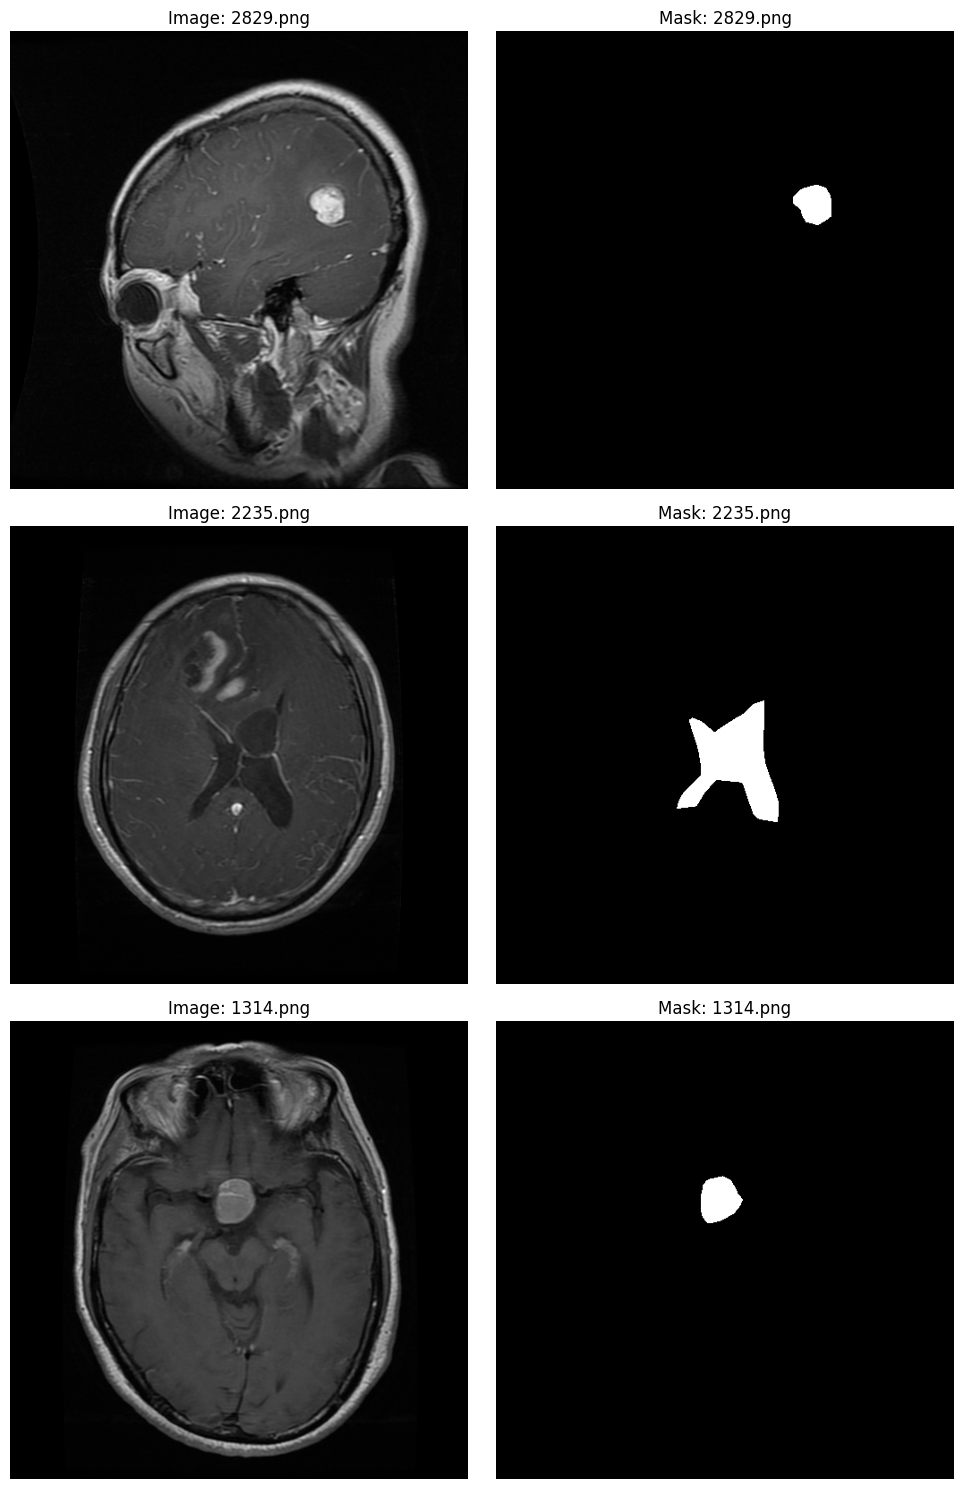

In [13]:
# Visualize some sample images and masks
def visualize_samples(pairs, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        img_path, mask_path = pairs[i]

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Image: {os.path.basename(img_path)}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask: {os.path.basename(mask_path)}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(train_pairs)

PART 6:DATA PIPELINE FUNCTION

In [14]:
def read_and_preprocess_image(image_path, mask_path):
    """Read and preprocess image and mask"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # Binarize mask

    return image, mask

print("Preprocessing function defined!")

Preprocessing function defined!


In [15]:
def data_augmentation(image, mask):
    """Apply data augmentation"""
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random brightness
    image = tf.image.random_brightness(image, 0.2)

    # Ensure values are still in valid range
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, mask

print("Data augmentation function defined!")

Data augmentation function defined!


In [16]:
def create_dataset(pairs, batch_size=8, training=True):
    """Create TensorFlow dataset"""
    images = [pair[0] for pair in pairs]
    masks = [pair[1] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

print("Dataset creation function defined!")

Dataset creation function defined!


PART 7:CREATE DATASETS

In [17]:
# Create datasets
train_dataset = create_dataset(train_pairs, BATCH_SIZE, training=True)
test_dataset = create_dataset(test_pairs, BATCH_SIZE, training=False)

print("Training and test datasets created successfully!")
print(f"Training batches: {len(list(train_dataset))}")
print(f"Test batches: {len(list(test_dataset))}")

Training and test datasets created successfully!
Training batches: 307
Test batches: 77


PART 8: Build DeepLabV3+ Model - Component 1

In [18]:
# DeepLabV3+ Implementation - Basic building blocks
def convolution_block(x, filters, kernel_size=3, dilation_rate=1, use_bias=False):
    """Convolution block with batch normalization and ReLU"""
    x = layers.Conv2D(
        filters,
        kernel_size,
        padding='same',
        use_bias=use_bias,
        dilation_rate=dilation_rate
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

print("Convolution block defined!")

Convolution block defined!


In [19]:
# Test the convolution block
test_input = keras.Input(shape=(256, 256, 3))
test_output = convolution_block(test_input, 32)
test_model = keras.Model(inputs=test_input, outputs=test_output)
print("Convolution block test successful!")
print(f"Input shape: {test_input.shape}, Output shape: {test_output.shape}")

Convolution block test successful!
Input shape: (None, 256, 256, 3), Output shape: (None, 256, 256, 32)


PART 9: Build DeepLabV3+ Model - Component 2


In [20]:
def dilated_spatial_pyramid_pooling(dspp_input):
    """Dilated Spatial Pyramid Pooling module"""
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, filters=256, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)

    out_1 = convolution_block(dspp_input, filters=256, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, filters=256, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, filters=256, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, filters=256, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, filters=256, kernel_size=1)
    return output

print("ASPP module defined!")

ASPP module defined!


PART 10: Build Complete DeepLabV3+ Model

In [22]:
def build_deeplabv3_plus(input_shape=(256, 256, 3), num_classes=1):
    """Build DeepLabV3+ model"""
    model_input = keras.Input(shape=input_shape)

    # Pre-trained ResNet50 as backbone
    resnet50 = keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=model_input
    )

    # Extract required layers for skip connections
    x = resnet50.get_layer("conv4_block6_out").output
    x = dilated_spatial_pyramid_pooling(x)

    input_a = layers.UpSampling2D(
        size=(input_shape[0] // 4 // x.shape[1], input_shape[1] // 4 // x.shape[2]),
        interpolation='bilinear'
    )(x)

    input_b = resnet50.get_layer("conv2_block3_out").output
    input_b = convolution_block(input_b, filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x, filters=256)
    x = convolution_block(x, filters=256)
    x = layers.UpSampling2D(
        size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]),
        interpolation='bilinear'
    )(x)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)

    return keras.Model(inputs=model_input, outputs=model_output)

print("DeepLabV3+ model builder defined!")

DeepLabV3+ model builder defined!


PART 11: Create Model and Check Architecture

In [23]:
# Build the model
print("Building DeepLabV3+ model...")
model = build_deeplabv3_plus(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Model built successfully!")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

# Show model summary
print("\nModel Summary:")
model.summary()

Building DeepLabV3+ model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built successfully!
Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 1)

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,830,465 (68.02 MB)

 Trainable params: 17,795,681 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

PART 12: Custom Metrics and Loss Functions

In [24]:
# Custom metrics for segmentation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    """IoU (Jaccard) metric"""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    """Combined BCE and Dice loss"""
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

print("Custom metrics and loss functions defined!")

Custom metrics and loss functions defined!


PART 13: Compile the Model


In [25]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, iou_metric]
)

print("Model compiled successfully!")
print("Optimizer: Adam (lr=1e-4)")
print("Loss: BCE + Dice Loss")
print("Metrics: Accuracy, Dice Coefficient, IoU")

Model compiled successfully!
Optimizer: Adam (lr=1e-4)
Loss: BCE + Dice Loss
Metrics: Accuracy, Dice Coefficient, IoU


PART 14: Setup Training Callbacks


In [26]:
# Setup callbacks for training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_deeplabv3_model.h5',
        monitor='val_dice_coefficient',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
]

print("Training callbacks setup complete!")
print("1. ModelCheckpoint - Saves best model based on validation Dice")
print("2. ReduceLROnPlateau - Reduces LR when validation loss plateaus")
print("3. EarlyStopping - Stops training if no improvement for 15 epochs")

Training callbacks setup complete!
1. ModelCheckpoint - Saves best model based on validation Dice
2. ReduceLROnPlateau - Reduces LR when validation loss plateaus
3. EarlyStopping - Stops training if no improvement for 15 epochs


PART 15: Start Initial Training (First 10 Epochs)

In [27]:
# Start with a smaller number of epochs to test
INITIAL_EPOCHS = 10

print("Starting initial training (10 epochs)...")
print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(test_pairs)}")
print(f"Batch size: {BATCH_SIZE}")

# Train the model
history = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Initial training completed!")

Starting initial training (10 epochs)...
Training samples: 2451
Validation samples: 613
Batch size: 8
Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8897 - dice_coefficient: 0.2807 - iou_metric: 0.1769 - loss: 0.9401
Epoch 1: val_dice_coefficient improved from -inf to 0.02409, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 252s 524ms/step - accuracy: 0.8899 - dice_coefficient: 0.2812 - iou_metric: 0.1773 - loss: 0.9392 - val_accuracy: 0.9828 - val_dice_coefficient: 0.0241 - val_iou_metric: 0.0122 - val_loss: 1.0576 - learning_rate: 1.0000e-04
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9916 - dice_coefficient: 0.6652 - iou_metric: 0.5043 - loss: 0.3669
Epoch 2: val_dice_coefficient improved from 0.02409 to 0.20792, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 349ms/step - accuracy: 0.9916 - dice_coefficient: 0.6654 - iou_metric: 0.5045 - loss: 0.3668 - val_accuracy: 0.9844 - val_dice_coefficient: 0.2079 - val_iou_metric: 0.1215 - val_loss: 0.8713 - learning_rate: 1.0000e-04
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9941 - dice_coefficient: 0.7766 - iou_metric: 0.6386 - loss: 0.2466
Epoch 3: val_dice_coefficient improved from 0.20792 to 0.48200, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 347ms/step - accuracy: 0.9941 - dice_coefficient: 0.7766 - iou_metric: 0.6387 - loss: 0.2466 - val_accuracy: 0.9876 - val_dice_coefficient: 0.4820 - val_iou_metric: 0.3290 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9947 - dice_coefficient: 0.8137 - iou_metric: 0.6893 - loss: 0.2073
Epoch 4: val_dice_coefficient improved from 0.48200 to 0.74213, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 348ms/step - accuracy: 0.9947 - dice_coefficient: 0.8137 - iou_metric: 0.6893 - loss: 0.2073 - val_accuracy: 0.9922 - val_dice_coefficient: 0.7421 - val_iou_metric: 0.5951 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9955 - dice_coefficient: 0.8439 - iou_metric: 0.7327 - loss: 0.1740
Epoch 5: val_dice_coefficient improved from 0.74213 to 0.76927, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 348ms/step - accuracy: 0.9955 - dice_coefficient: 0.8439 - iou_metric: 0.7327 - loss: 0.1740 - val_accuracy: 0.9931 - val_dice_coefficient: 0.7693 - val_iou_metric: 0.6304 - val_loss: 0.2633 - learning_rate: 1.0000e-04
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9959 - dice_coefficient: 0.8621 - iou_metric: 0.7599 - loss: 0.1541
Epoch 6: val_dice_coefficient improved from 0.76927 to 0.78787, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 348ms/step - accuracy: 0.9959 - dice_coefficient: 0.8621 - iou_metric: 0.7599 - loss: 0.1541 - val_accuracy: 0.9937 - val_dice_coefficient: 0.7879 - val_iou_metric: 0.6557 - val_loss: 0.2439 - learning_rate: 1.0000e-04
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9960 - dice_coefficient: 0.8698 - iou_metric: 0.7717 - loss: 0.1466
Epoch 7: val_dice_coefficient improved from 0.78787 to 0.78814, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 347ms/step - accuracy: 0.9960 - dice_coefficient: 0.8698 - iou_metric: 0.7717 - loss: 0.1466 - val_accuracy: 0.9936 - val_dice_coefficient: 0.7881 - val_iou_metric: 0.6551 - val_loss: 0.2442 - learning_rate: 1.0000e-04
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9964 - dice_coefficient: 0.8809 - iou_metric: 0.7888 - loss: 0.1338
Epoch 8: val_dice_coefficient did not improve from 0.78814
307/307 ━━━━━━━━━━━━━━━━━━━━ 111s 344ms/step - accuracy: 0.9964 - dice_coefficient: 0.8809 - iou_metric: 0.7888 - loss: 0.1338 - val_accuracy: 0.9937 - val_dice_coefficient: 0.7867 - val_iou_metric: 0.6535 - val_loss: 0.2491 - learning_rate: 1.0000e-04
Epoch 9/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9968 - dice_coefficient: 0.8963 - iou_metric: 0.8132 - loss: 0.1164
Epoch 9: val_dice_coefficient improved from 0.78814 to 0.80735, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 348ms/step - accuracy: 0.9968 - dice_coefficient: 0.8963 - iou_metric: 0.8132 - loss: 0.1164 - val_accuracy: 0.9940 - val_dice_coefficient: 0.8073 - val_iou_metric: 0.6815 - val_loss: 0.2251 - learning_rate: 1.0000e-04
Epoch 10/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9970 - dice_coefficient: 0.8991 - iou_metric: 0.8185 - loss: 0.1131
Epoch 10: val_dice_coefficient improved from 0.80735 to 0.80740, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 348ms/step - accuracy: 0.9970 - dice_coefficient: 0.8991 - iou_metric: 0.8185 - loss: 0.1130 - val_accuracy: 0.9941 - val_dice_coefficient: 0.8074 - val_iou_metric: 0.6818 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.
Initial training completed!


PART 16: Check Initial Results


Initial Training Results:
Final Training Loss: 0.1096
Final Validation Loss: 0.2259
Final Training Dice: 0.9020
Final Validation Dice: 0.8074


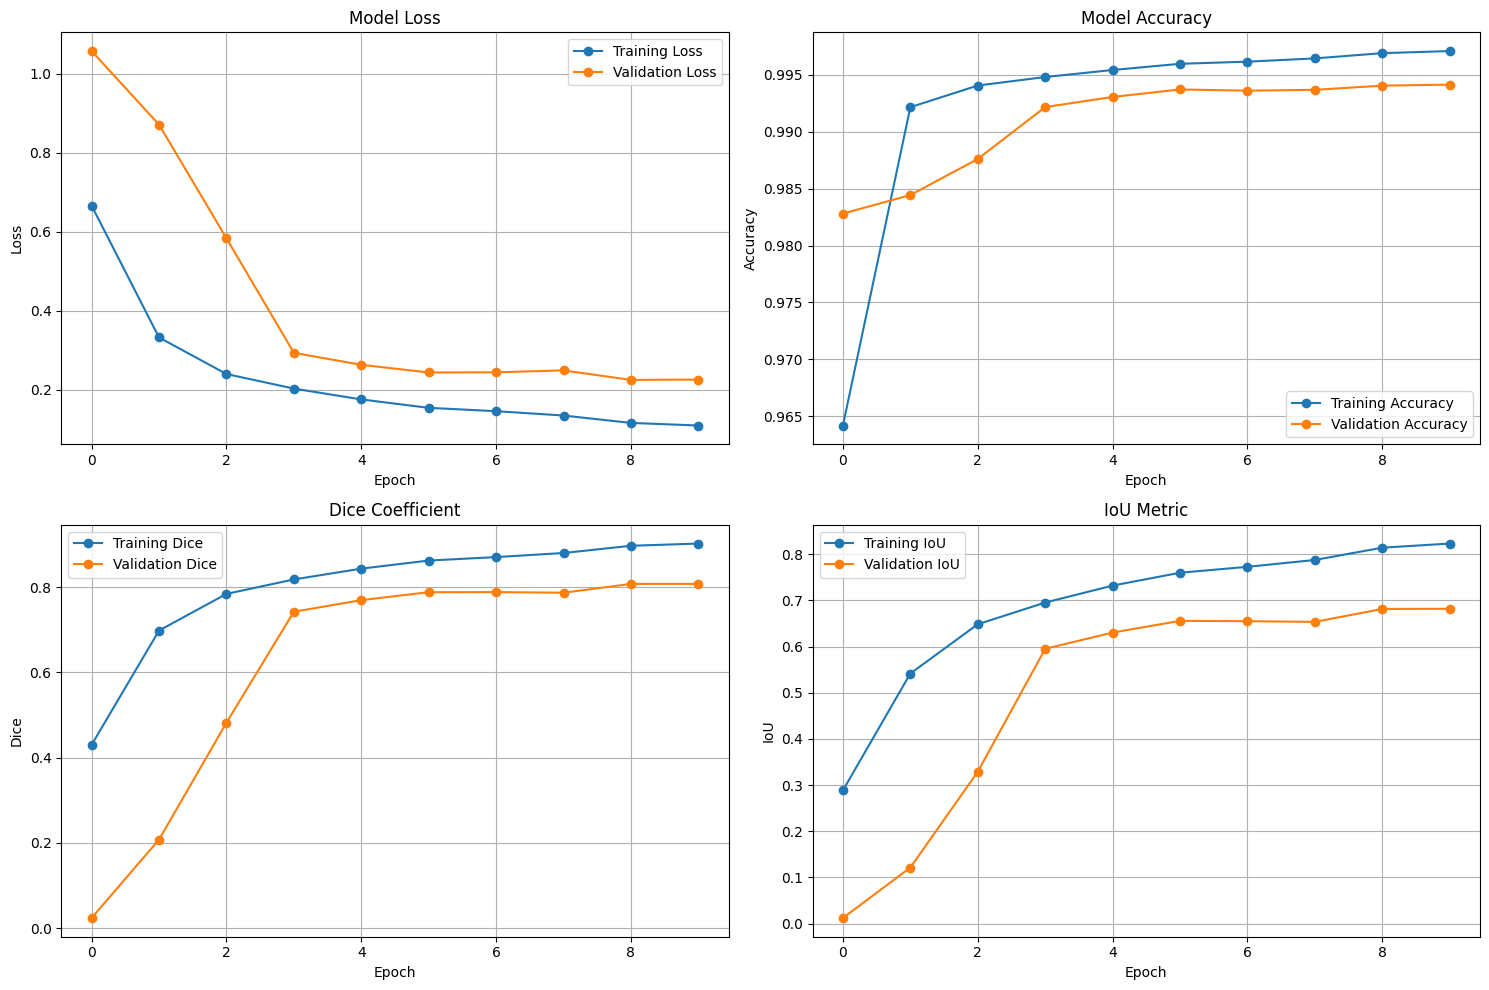

In [28]:
# Check initial training results
print("Initial Training Results:")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"Final Validation Dice: {history.history['val_dice_coefficient'][-1]:.4f}")

# Plot initial training history
def plot_initial_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Dice Coefficient
    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice', marker='o')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice', marker='o')
    axes[1, 0].set_title('Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # IoU
    axes[1, 1].plot(history.history['iou_metric'], label='Training IoU', marker='o')
    axes[1, 1].plot(history.history['val_iou_metric'], label='Validation IoU', marker='o')
    axes[1, 1].set_title('IoU Metric')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_initial_history(history)

PART 17: Continue Training (Next 10 Epochs)

In [29]:
# Continue training for more epochs
ADDITIONAL_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + ADDITIONAL_EPOCHS

print(f"Continuing training for {ADDITIONAL_EPOCHS} more epochs...")
print(f"Total epochs will be: {TOTAL_EPOCHS}")

# Continue training
history_continued = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Additional training completed!")

Continuing training for 10 more epochs...
Total epochs will be: 20
Epoch 11/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9968 - dice_coefficient: 0.8932 - iou_metric: 0.8091 - loss: 0.1200
Epoch 11: val_dice_coefficient did not improve from 0.80740
307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 348ms/step - accuracy: 0.9968 - dice_coefficient: 0.8932 - iou_metric: 0.8091 - loss: 0.1199 - val_accuracy: 0.9934 - val_dice_coefficient: 0.7919 - val_iou_metric: 0.6611 - val_loss: 0.2432 - learning_rate: 1.0000e-04
Epoch 12/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9969 - dice_coefficient: 0.9016 - iou_metric: 0.8222 - loss: 0.1110
Epoch 12: val_dice_coefficient did not improve from 0.80740
307/307 ━━━━━━━━━━━━━━━━━━━━ 111s 345ms/step - accuracy: 0.9969 - dice_coefficient: 0.9017 - iou_metric: 0.8223 - loss: 0.1110 - val_accuracy: 0.9939 - val_dice_coefficient: 0.7961 - val_iou_metric: 0.6661 - val_loss: 0.2410 - learning_rate: 1.0000e-04
Epoch 13/20
307/307 ━━━━━━━━━━━━━

307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 347ms/step - accuracy: 0.9973 - dice_coefficient: 0.9129 - iou_metric: 0.8413 - loss: 0.0980 - val_accuracy: 0.9942 - val_dice_coefficient: 0.8115 - val_iou_metric: 0.6889 - val_loss: 0.2239 - learning_rate: 1.0000e-04
Epoch 14/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9977 - dice_coefficient: 0.9239 - iou_metric: 0.8594 - loss: 0.0856
Epoch 14: val_dice_coefficient improved from 0.81146 to 0.81905, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 351ms/step - accuracy: 0.9977 - dice_coefficient: 0.9239 - iou_metric: 0.8594 - loss: 0.0856 - val_accuracy: 0.9943 - val_dice_coefficient: 0.8191 - val_iou_metric: 0.6989 - val_loss: 0.2159 - learning_rate: 1.0000e-04
Epoch 15/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9976 - dice_coefficient: 0.9218 - iou_metric: 0.8560 - loss: 0.0881
Epoch 15: val_dice_coefficient did not improve from 0.81905
307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 344ms/step - accuracy: 0.9976 - dice_coefficient: 0.9218 - iou_metric: 0.8560 - loss: 0.0881 - val_accuracy: 0.9941 - val_dice_coefficient: 0.8102 - val_iou_metric: 0.6864 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 16/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9976 - dice_coefficient: 0.9202 - iou_metric: 0.8534 - loss: 0.0898
Epoch 16: val_dice_coefficient did not improve from 0.81905
307/307 ━━━━━━━━━━━━━━━━━━━━ 111s 343ms/step - accuracy: 0.9976 - dice_coefficient: 0.9202 - iou_met

307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 346ms/step - accuracy: 0.9980 - dice_coefficient: 0.9320 - iou_metric: 0.8735 - loss: 0.0759 - val_accuracy: 0.9945 - val_dice_coefficient: 0.8256 - val_iou_metric: 0.7081 - val_loss: 0.2108 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 20.
Additional training completed!


PART 18: Combine History and Check Progress

In [30]:
# Combine history from both training sessions
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

combined_history = combine_histories(history, history_continued)

print("Training Progress Summary:")
print(f"Total epochs trained: {len(combined_history['loss'])}")
print(f"Best Validation Dice: {max(combined_history['val_dice_coefficient']):.4f}")
print(f"Best Validation IoU: {max(combined_history['val_iou_metric']):.4f}")

Training Progress Summary:
Total epochs trained: 20
Best Validation Dice: 0.8256
Best Validation IoU: 0.7081


PART 19: Continue Training (More Epochs)

In [31]:
# Check current best performance
current_best_dice = max(combined_history['val_dice_coefficient'])
print(f"Current best validation Dice: {current_best_dice:.4f}")

# Continue training for more epochs if needed
if current_best_dice < 0.85:  # If we haven't reached good performance yet
    MORE_EPOCHS = 15
    print(f"Continuing training for {MORE_EPOCHS} more epochs...")

    history_more = model.fit(
        train_dataset,
        epochs=len(combined_history['loss']) + MORE_EPOCHS,
        initial_epoch=len(combined_history['loss']),
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=1
    )

    # Update combined history
    for key in combined_history.keys():
        combined_history[key] += history_more.history[key]

    print("Additional training completed!")
else:
    print("Good performance achieved! Moving to evaluation...")

print(f"Total epochs trained: {len(combined_history['loss'])}")
print(f"Final Validation Dice: {combined_history['val_dice_coefficient'][-1]:.4f}")

Current best validation Dice: 0.8256
Continuing training for 15 more epochs...
Epoch 21/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9983 - dice_coefficient: 0.9448 - iou_metric: 0.8961 - loss: 0.0621
Epoch 21: val_dice_coefficient did not improve from 0.82556
307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 343ms/step - accuracy: 0.9983 - dice_coefficient: 0.9448 - iou_metric: 0.8961 - loss: 0.0621 - val_accuracy: 0.9944 - val_dice_coefficient: 0.8195 - val_iou_metric: 0.6991 - val_loss: 0.2194 - learning_rate: 5.0000e-05
Epoch 22/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9986 - dice_coefficient: 0.9516 - iou_metric: 0.9080 - loss: 0.0541
Epoch 22: val_dice_coefficient improved from 0.82556 to 0.82861, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 345ms/step - accuracy: 0.9986 - dice_coefficient: 0.9516 - iou_metric: 0.9080 - loss: 0.0541 - val_accuracy: 0.9945 - val_dice_coefficient: 0.8286 - val_iou_metric: 0.7129 - val_loss: 0.2125 - learning_rate: 5.0000e-05
Epoch 23/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9987 - dice_coefficient: 0.9560 - iou_metric: 0.9160 - loss: 0.0490
Epoch 23: val_dice_coefficient did not improve from 0.82861
307/307 ━━━━━━━━━━━━━━━━━━━━ 111s 342ms/step - accuracy: 0.9987 - dice_coefficient: 0.9560 - iou_metric: 0.9159 - loss: 0.0490 - val_accuracy: 0.9946 - val_dice_coefficient: 0.8245 - val_iou_metric: 0.7066 - val_loss: 0.2200 - learning_rate: 5.0000e-05
Epoch 24/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9986 - dice_coefficient: 0.9527 - iou_metric: 0.9101 - loss: 0.0536
Epoch 24: val_dice_coefficient did not improve from 0.82861
307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 349ms/step - accuracy: 0.9986 - dice_coefficient: 0.9527 - iou_met

307/307 ━━━━━━━━━━━━━━━━━━━━ 115s 355ms/step - accuracy: 0.9989 - dice_coefficient: 0.9626 - iou_metric: 0.9286 - loss: 0.0424 - val_accuracy: 0.9946 - val_dice_coefficient: 0.8292 - val_iou_metric: 0.7135 - val_loss: 0.2185 - learning_rate: 2.5000e-05
Epoch 32/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9990 - dice_coefficient: 0.9653 - iou_metric: 0.9332 - loss: 0.0390
Epoch 32: val_dice_coefficient improved from 0.82921 to 0.83208, saving model to best_deeplabv3_model.h5



Epoch 32: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
307/307 ━━━━━━━━━━━━━━━━━━━━ 118s 365ms/step - accuracy: 0.9990 - dice_coefficient: 0.9653 - iou_metric: 0.9332 - loss: 0.0390 - val_accuracy: 0.9947 - val_dice_coefficient: 0.8321 - val_iou_metric: 0.7176 - val_loss: 0.2147 - learning_rate: 2.5000e-05
Epoch 33/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9990 - dice_coefficient: 0.9662 - iou_metric: 0.9351 - loss: 0.0379
Epoch 33: val_dice_coefficient improved from 0.83208 to 0.83394, saving model to best_deeplabv3_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 119s 368ms/step - accuracy: 0.9990 - dice_coefficient: 0.9662 - iou_metric: 0.9351 - loss: 0.0379 - val_accuracy: 0.9948 - val_dice_coefficient: 0.8339 - val_iou_metric: 0.7203 - val_loss: 0.2142 - learning_rate: 1.2500e-05
Epoch 34/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9990 - dice_coefficient: 0.9673 - iou_metric: 0.9370 - loss: 0.0371
Epoch 34: val_dice_coefficient did not improve from 0.83394
307/307 ━━━━━━━━━━━━━━━━━━━━ 113s 350ms/step - accuracy: 0.9990 - dice_coefficient: 0.9673 - iou_metric: 0.9370 - loss: 0.0371 - val_accuracy: 0.9948 - val_dice_coefficient: 0.8324 - val_iou_metric: 0.7182 - val_loss: 0.2159 - learning_rate: 1.2500e-05
Epoch 35/35
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9992 - dice_coefficient: 0.9713 - iou_metric: 0.9444 - loss: 0.0319
Epoch 35: val_dice_coefficient did not improve from 0.83394
307/307 ━━━━━━━━━━━━━━━━━━━━ 112s 342ms/step - accuracy: 0.9992 - dice_coefficient: 0.9713 - iou_met

PART 20: Final Training Progress Plot

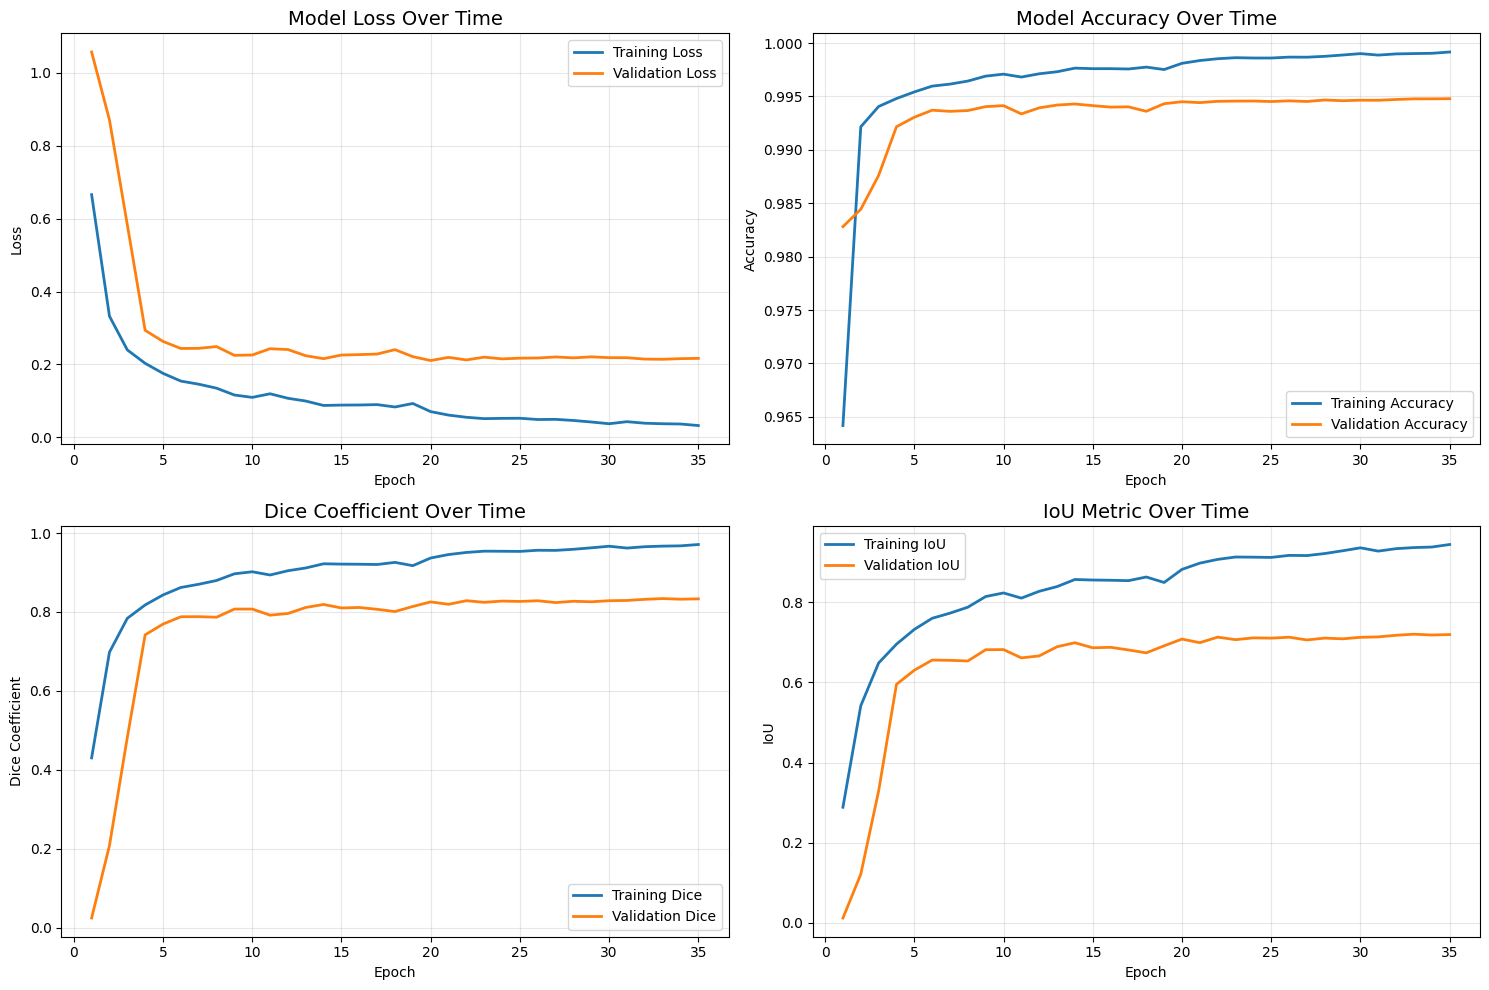

In [32]:
# Plot complete training history
def plot_complete_history(history_dict):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs_range = range(1, len(history_dict['loss']) + 1)

    # Loss
    axes[0, 0].plot(epochs_range, history_dict['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs_range, history_dict['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss Over Time', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs_range, history_dict['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Model Accuracy Over Time', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Dice Coefficient
    axes[1, 0].plot(epochs_range, history_dict['dice_coefficient'], label='Training Dice', linewidth=2)
    axes[1, 0].plot(epochs_range, history_dict['val_dice_coefficient'], label='Validation Dice', linewidth=2)
    axes[1, 0].set_title('Dice Coefficient Over Time', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Coefficient')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # IoU
    axes[1, 1].plot(epochs_range, history_dict['iou_metric'], label='Training IoU', linewidth=2)
    axes[1, 1].plot(epochs_range, history_dict['val_iou_metric'], label='Validation IoU', linewidth=2)
    axes[1, 1].set_title('IoU Metric Over Time', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('IoU')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_complete_history(combined_history)

PART 21: Load Best Model and Evaluate

In [33]:
# Load the best saved model
print("Loading the best model from checkpoint...")
best_model = keras.models.load_model('best_deeplabv3_model.h5',
                                   custom_objects={
                                       'dice_coefficient': dice_coefficient,
                                       'iou_metric': iou_metric,
                                       'bce_dice_loss': bce_dice_loss
                                   })

print("Best model loaded successfully!")

# Evaluate on test set
print("Evaluating best model on test set...")
test_results = best_model.evaluate(test_dataset, verbose=1)

print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Dice Coefficient: {test_results[2]:.4f}")
print(f"Test IoU: {test_results[3]:.4f}")
print("="*50)

Loading the best model from checkpoint...


Best model loaded successfully!
Evaluating best model on test set...
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.9946 - dice_coefficient: 0.8293 - iou_metric: 0.7134 - loss: 0.2206

FINAL TEST RESULTS
Test Loss: 0.2142
Test Accuracy: 0.9948
Test Dice Coefficient: 0.8339
Test IoU: 0.7203


PART 22: Detailed Prediction Visualization

Generating detailed predictions...


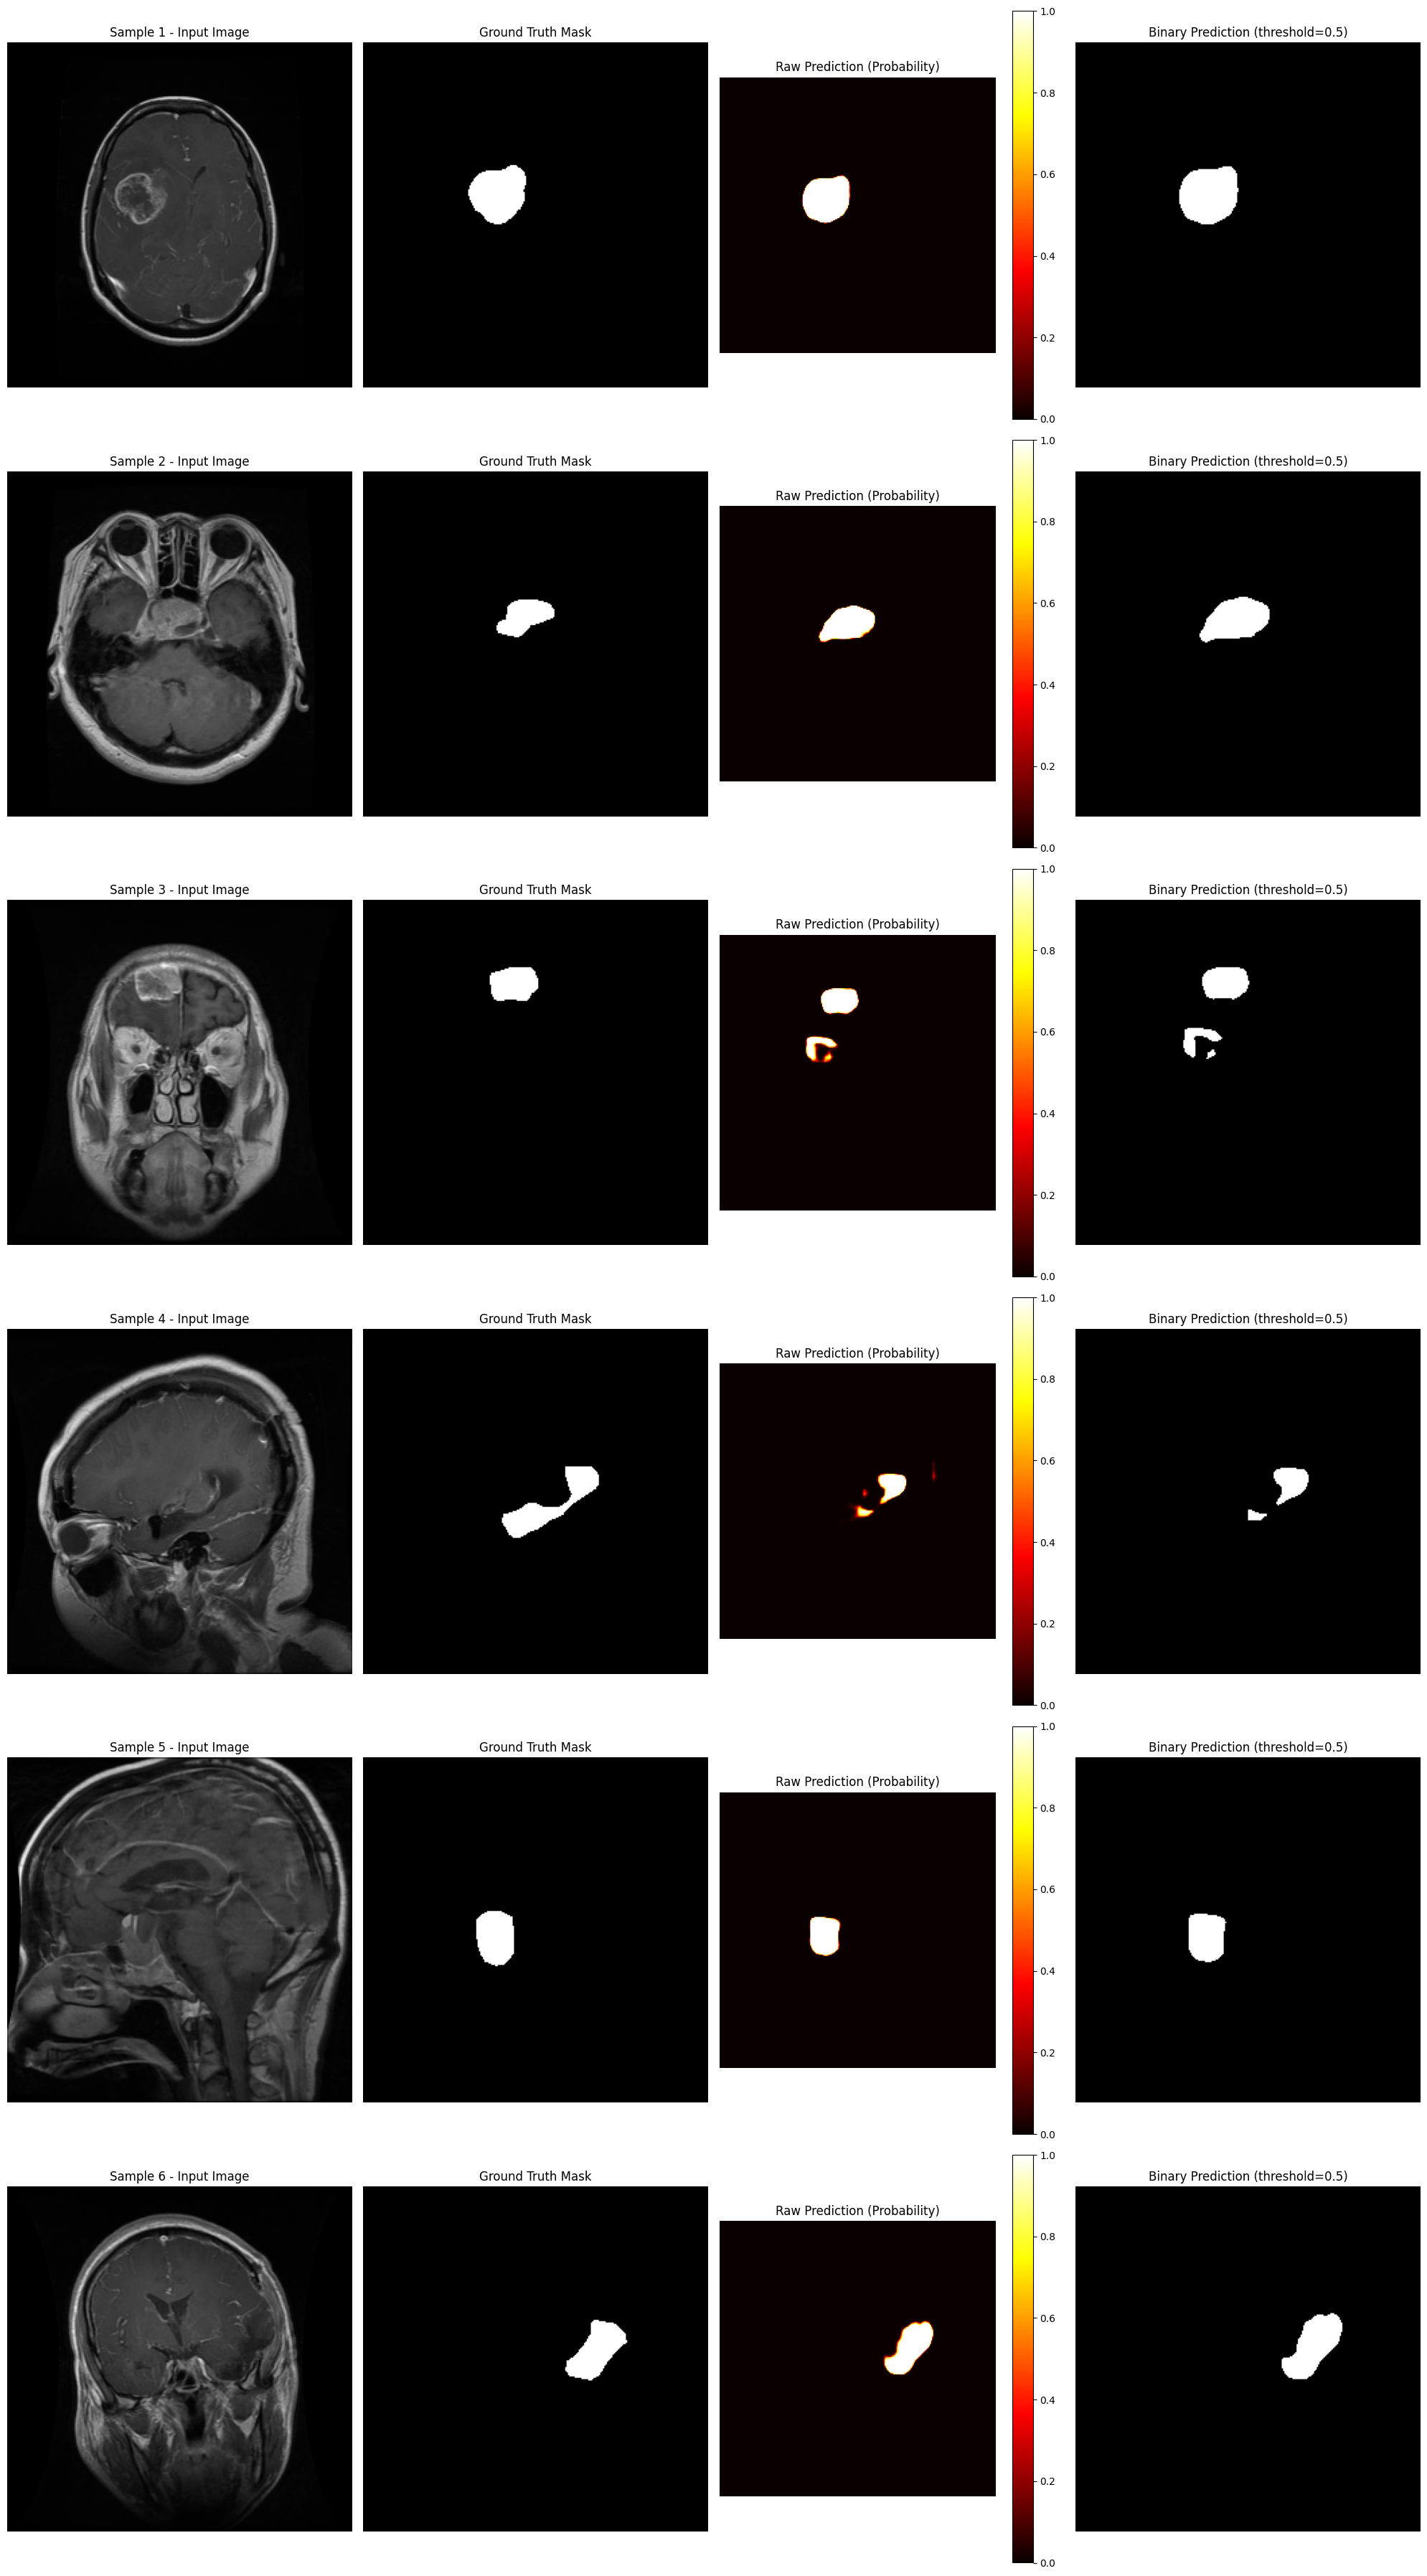

In [34]:
def detailed_predictions(model, dataset, num_samples=6):
    """Show detailed predictions with different thresholds"""
    samples = list(dataset.take(num_samples).as_numpy_iterator())

    plt.figure(figsize=(20, 6 * num_samples))

    for i, (images, masks) in enumerate(samples):
        if i >= num_samples:
            break

        # Predict
        predictions = model.predict(images, verbose=0)

        for j in range(min(1, len(images))):  # Show 1 sample per batch for clarity
            idx = i * 4  # 4 subplots per sample

            # Original Image
            plt.subplot(num_samples, 4, idx + 1)
            plt.imshow(images[j])
            plt.title(f'Sample {i+1} - Input Image', fontsize=12)
            plt.axis('off')

            # Ground Truth
            plt.subplot(num_samples, 4, idx + 2)
            plt.imshow(masks[j].squeeze(), cmap='gray')
            plt.title('Ground Truth Mask', fontsize=12)
            plt.axis('off')

            # Raw Prediction
            plt.subplot(num_samples, 4, idx + 3)
            plt.imshow(predictions[j].squeeze(), cmap='hot')
            plt.title('Raw Prediction (Probability)', fontsize=12)
            plt.colorbar()
            plt.axis('off')

            # Binary Prediction (threshold=0.5)
            plt.subplot(num_samples, 4, idx + 4)
            binary_pred = (predictions[j].squeeze() > 0.5).astype(np.float32)
            plt.imshow(binary_pred, cmap='gray')
            plt.title('Binary Prediction (threshold=0.5)', fontsize=12)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Generating detailed predictions...")
detailed_predictions(best_model, test_dataset)

PART 23: Quantitative Analysis

In [35]:
# Calculate additional metrics on test set
def calculate_detailed_metrics(model, test_pairs, threshold=0.5):
    """Calculate precision, recall, and F1-score"""
    dice_scores = []
    iou_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for img_path, mask_path in test_pairs[:100]:  # Use first 100 for speed
        # Load and preprocess
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.expand_dims(image, axis=0)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
        mask = tf.where(mask > 0.5, 1.0, 0.0)

        # Predict
        pred = model.predict(image, verbose=0)[0]
        binary_pred = (pred > threshold).astype(np.float32)

        # Calculate metrics
        y_true = mask.numpy().flatten()
        y_pred = binary_pred.flatten()

        # Dice
        intersection = np.sum(y_true * y_pred)
        dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)
        dice_scores.append(dice)

        # IoU
        union = np.sum(y_true) + np.sum(y_pred) - intersection
        iou = intersection / (union + 1e-6)
        iou_scores.append(iou)

        # Precision, Recall, F1
        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))
        false_negatives = np.sum((y_true == 1) & (y_pred == 0))

        precision = true_positives / (true_positives + false_positives + 1e-6)
        recall = true_positives / (true_positives + false_negatives + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'dice': np.mean(dice_scores),
        'iou': np.mean(iou_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores)
    }

print("Calculating detailed metrics...")
detailed_metrics = calculate_detailed_metrics(best_model, test_pairs)

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(f"Dice Coefficient: {detailed_metrics['dice']:.4f}")
print(f"IoU (Jaccard): {detailed_metrics['iou']:.4f}")
print(f"Precision: {detailed_metrics['precision']:.4f}")
print(f"Recall: {detailed_metrics['recall']:.4f}")
print(f"F1-Score: {detailed_metrics['f1']:.4f}")
print("="*60)

Calculating detailed metrics...

DETAILED PERFORMANCE METRICS
Dice Coefficient: 0.7849
IoU (Jaccard): 0.6956
Precision: 0.8404
Recall: 0.7771
F1-Score: 0.7849


PART 24: Save Final Model and Results

In [36]:
# Save the final trained model
final_model_path = 'final_deeplabv3_brain_tumor_model.h5'
best_model.save(final_model_path)
print(f"Final model saved as: {final_model_path}")

# Save training history for future reference
import pickle
history_path = 'training_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(combined_history, f)
print(f"Training history saved as: {history_path}")

# Create a summary file
summary = f"""
BRAIN TUMOR SEGMENTATION - DEEPLABV3+ MODEL SUMMARY
==================================================
Dataset: Brain Tumor Segmentation (Kaggle)
Total Samples: {len(pairs)}
Training Samples: {len(train_pairs)}
Test Samples: {len(test_pairs)}
Image Size: {IMG_HEIGHT}x{IMG_WIDTH}
Batch Size: {BATCH_SIZE}
Total Epochs Trained: {len(combined_history['loss'])}

FINAL PERFORMANCE:
-----------------
Test Loss: {test_results[0]:.4f}
Test Accuracy: {test_results[1]:.4f}
Test Dice Coefficient: {test_results[2]:.4f}
Test IoU: {test_results[3]:.4f}

DETAILED METRICS:
----------------
Dice: {detailed_metrics['dice']:.4f}
IoU: {detailed_metrics['iou']:.4f}
Precision: {detailed_metrics['precision']:.4f}
Recall: {detailed_metrics['recall']:.4f}
F1-Score: {detailed_metrics['f1']:.4f}

TRAINING PROGRESS:
-----------------
Best Validation Dice: {max(combined_history['val_dice_coefficient']):.4f}
Best Validation IoU: {max(combined_history['val_iou_metric']):.4f}
Final Validation Dice: {combined_history['val_dice_coefficient'][-1]:.4f}
Final Validation IoU: {combined_history['val_iou_metric'][-1]:.4f}
"""

print(summary)

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write(summary)

print("Model summary saved to 'model_summary.txt'")

Final model saved as: final_deeplabv3_brain_tumor_model.h5
Training history saved as: training_history.pkl

BRAIN TUMOR SEGMENTATION - DEEPLABV3+ MODEL SUMMARY
Dataset: Brain Tumor Segmentation (Kaggle)
Total Samples: 3064
Training Samples: 2451
Test Samples: 613
Image Size: 256x256
Batch Size: 8
Total Epochs Trained: 35

FINAL PERFORMANCE:
-----------------
Test Loss: 0.2142
Test Accuracy: 0.9948
Test Dice Coefficient: 0.8339
Test IoU: 0.7203

DETAILED METRICS:
----------------
Dice: 0.7849
IoU: 0.6956
Precision: 0.8404
Recall: 0.7771
F1-Score: 0.7849

TRAINING PROGRESS:
-----------------
Best Validation Dice: 0.8339
Best Validation IoU: 0.7203
Final Validation Dice: 0.8333
Final Validation IoU: 0.7194

Model summary saved to 'model_summary.txt'


PART 25: Final Visualization with Confidence

Generating final confidence-based predictions...


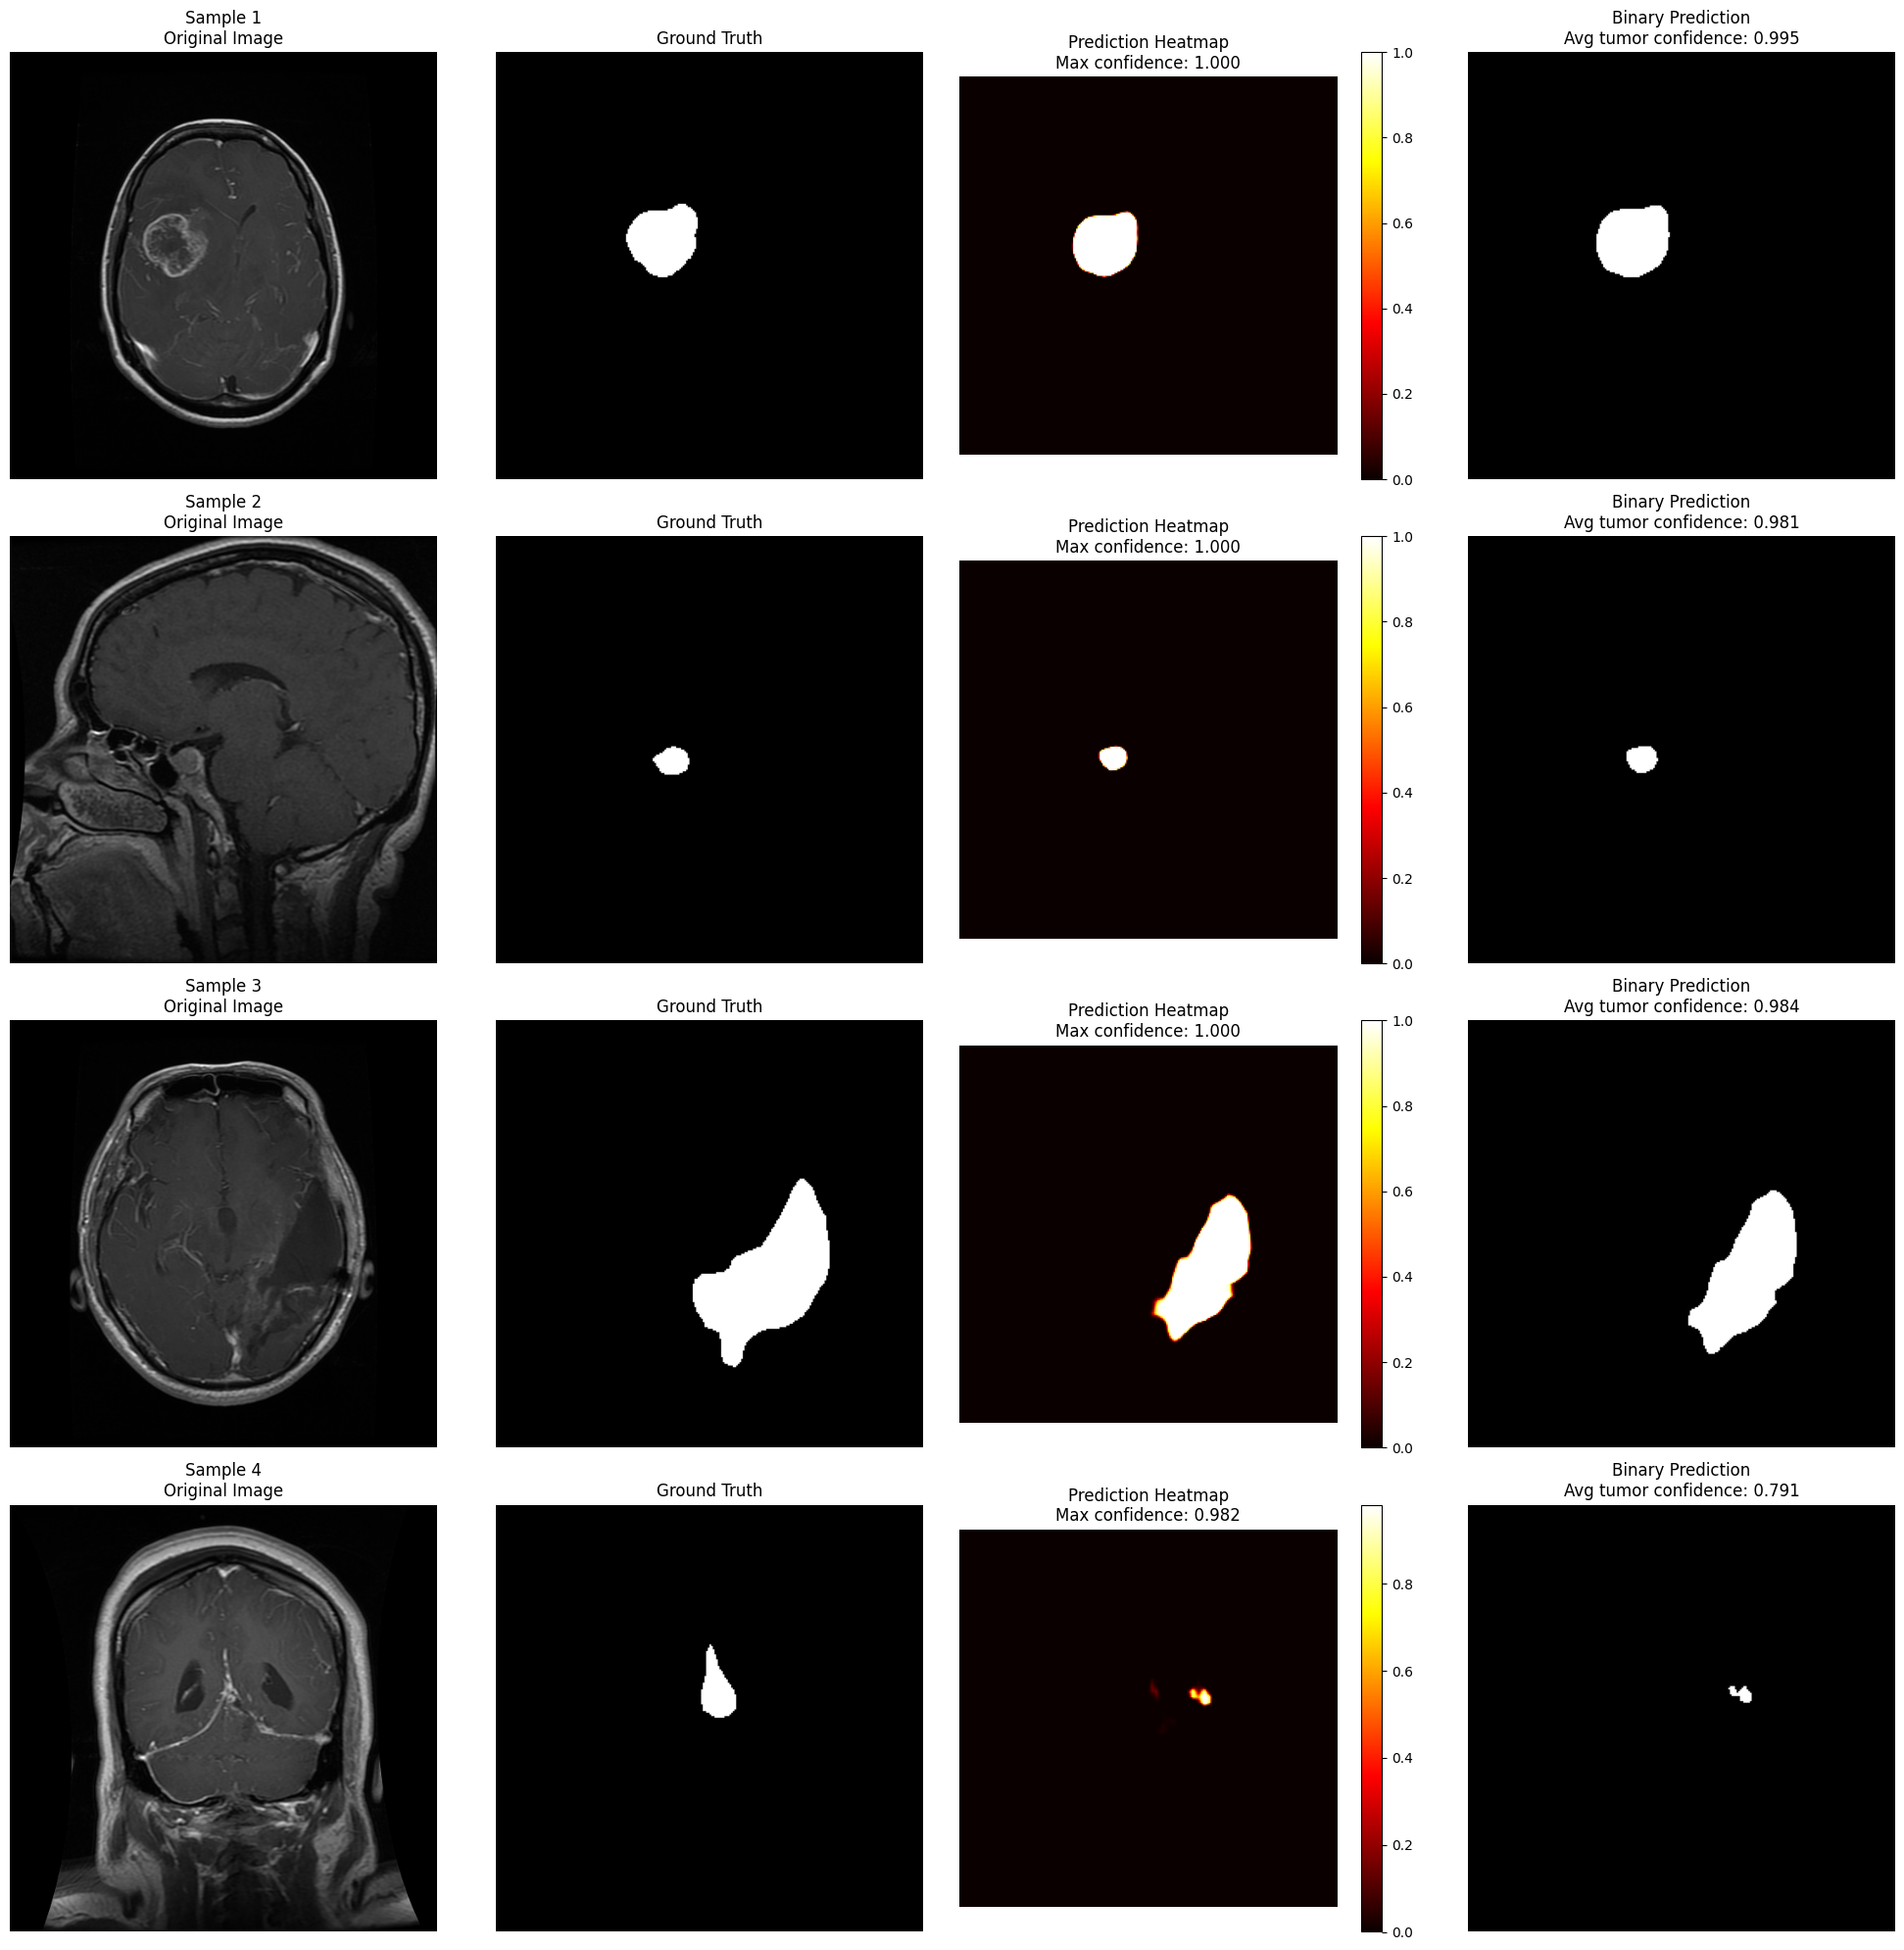


🎉 TRAINING AND EVALUATION COMPLETE! 🎉
Your DeepLabV3+ model is ready for brain tumor segmentation!
Model achieved Dice Coefficient: 0.8339


In [37]:
# Show predictions with confidence scores
def predictions_with_confidence(model, test_pairs, num_samples=4):
    """Show predictions with confidence scores"""
    plt.figure(figsize=(20, 5 * num_samples))

    for i in range(num_samples):
        img_path, mask_path = test_pairs[i]

        # Load and preprocess
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image_resized = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image_batch = tf.expand_dims(image_resized, axis=0)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask_resized = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
        mask_binary = tf.where(mask_resized > 0.5, 1.0, 0.0)

        # Predict
        prediction = model.predict(image_batch, verbose=0)[0]
        binary_pred = (prediction > 0.5).astype(np.float32)

        # Calculate confidence (average probability in predicted tumor region)
        tumor_confidence = np.mean(prediction[binary_pred == 1]) if np.any(binary_pred == 1) else 0.0

        # Plot
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(image)
        plt.title(f'Sample {i+1}\nOriginal Image', fontsize=12)
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(mask_binary.numpy().squeeze(), cmap='gray')
        plt.title('Ground Truth', fontsize=12)
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(prediction.squeeze(), cmap='hot')
        plt.title(f'Prediction Heatmap\nMax confidence: {np.max(prediction):.3f}', fontsize=12)
        plt.colorbar()
        plt.axis('off')

        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(binary_pred.squeeze(), cmap='gray')
        plt.title(f'Binary Prediction\nAvg tumor confidence: {tumor_confidence:.3f}', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Generating final confidence-based predictions...")
predictions_with_confidence(best_model, test_pairs)

print("\n🎉 TRAINING AND EVALUATION COMPLETE! 🎉")
print("Your DeepLabV3+ model is ready for brain tumor segmentation!")
print(f"Model achieved Dice Coefficient: {test_results[2]:.4f}")

PART 26: Check Model Accuracy - Multiple Methods

In [38]:
# Method 1: Basic Model Evaluation (Already done)
print("METHOD 1: Basic Model Evaluation")
print("="*40)
test_loss, test_accuracy, test_dice, test_iou = best_model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Loss: {test_loss:.4f}")

METHOD 1: Basic Model Evaluation
Test Accuracy: 0.9948 (99.48%)
Test Dice: 0.8339
Test IoU: 0.7203
Test Loss: 0.2142


In [39]:
# Method 2: Detailed Accuracy Calculation
def calculate_detailed_accuracy(model, dataset):
    """Calculate pixel-wise accuracy and class-wise accuracy"""
    total_pixels = 0
    correct_pixels = 0
    tumor_pixels_correct = 0
    total_tumor_pixels = 0
    background_pixels_correct = 0
    total_background_pixels = 0

    for images, masks in dataset:
        predictions = model.predict(images, verbose=0)
        binary_predictions = (predictions > 0.5).astype(np.float32)

        for i in range(len(images)):
            pred = binary_predictions[i]
            true_mask = masks[i].numpy()

            # Pixel-wise accuracy
            correct_pixels += np.sum(pred == true_mask)
            total_pixels += np.prod(pred.shape)

            # Tumor class accuracy (class 1)
            tumor_mask = true_mask == 1
            if np.any(tumor_mask):
                tumor_pixels_correct += np.sum((pred == true_mask) & tumor_mask)
                total_tumor_pixels += np.sum(tumor_mask)

            # Background class accuracy (class 0)
            background_mask = true_mask == 0
            background_pixels_correct += np.sum((pred == true_mask) & background_mask)
            total_background_pixels += np.sum(background_mask)

    overall_accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0
    tumor_accuracy = tumor_pixels_correct / total_tumor_pixels if total_tumor_pixels > 0 else 0
    background_accuracy = background_pixels_correct / total_background_pixels if total_background_pixels > 0 else 0

    return {
        'overall_accuracy': overall_accuracy,
        'tumor_accuracy': tumor_accuracy,
        'background_accuracy': background_accuracy,
        'total_samples': len(list(dataset))
    }

print("\nMETHOD 2: Detailed Accuracy Analysis")
print("="*40)
detailed_acc = calculate_detailed_accuracy(best_model, test_dataset)
print(f"Overall Pixel Accuracy: {detailed_acc['overall_accuracy']:.4f} ({detailed_acc['overall_accuracy']*100:.2f}%)")
print(f"Tumor Region Accuracy: {detailed_acc['tumor_accuracy']:.4f} ({detailed_acc['tumor_accuracy']*100:.2f}%)")
print(f"Background Accuracy: {detailed_acc['background_accuracy']:.4f} ({detailed_acc['background_accuracy']*100:.2f}%)")
print(f"Test Samples: {detailed_acc['total_samples']}")


METHOD 2: Detailed Accuracy Analysis
Overall Pixel Accuracy: 0.9948 (99.48%)
Tumor Region Accuracy: 0.8118 (81.18%)
Background Accuracy: 0.9980 (99.80%)
Test Samples: 77


In [40]:
# Method 3: Per-Image Accuracy
def per_image_accuracy(model, test_pairs, num_samples=50):
    """Calculate accuracy for individual images"""
    accuracies = []
    dice_scores = []

    for img_path, mask_path in test_pairs[:num_samples]:
        # Load and preprocess
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image_batch = tf.expand_dims(image, axis=0)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
        mask_binary = tf.where(mask > 0.5, 1.0, 0.0)

        # Predict
        prediction = model.predict(image_batch, verbose=0)[0]
        binary_pred = (prediction > 0.5).astype(np.float32)

        # Calculate accuracy for this image
        accuracy = np.mean(binary_pred == mask_binary.numpy())
        accuracies.append(accuracy)

        # Calculate dice for this image
        intersection = np.sum(binary_pred * mask_binary.numpy())
        dice = (2. * intersection) / (np.sum(binary_pred) + np.sum(mask_binary.numpy()) + 1e-6)
        dice_scores.append(dice)

    return np.array(accuracies), np.array(dice_scores)

print("\nMETHOD 3: Per-Image Accuracy Analysis")
print("="*40)
per_image_acc, per_image_dice = per_image_accuracy(best_model, test_pairs)
print(f"Average Per-Image Accuracy: {np.mean(per_image_acc):.4f} (±{np.std(per_image_acc):.4f})")
print(f"Average Per-Image Dice: {np.mean(per_image_dice):.4f} (±{np.std(per_image_dice):.4f})")
print(f"Best Image Accuracy: {np.max(per_image_acc):.4f}")
print(f"Worst Image Accuracy: {np.min(per_image_acc):.4f}")


METHOD 3: Per-Image Accuracy Analysis
Average Per-Image Accuracy: 0.9936 (±0.0069)
Average Per-Image Dice: 0.7501 (±0.2675)
Best Image Accuracy: 0.9994
Worst Image Accuracy: 0.9633


In [41]:
# Method 4: Confidence-based Accuracy
def confidence_accuracy_analysis(model, test_pairs, num_samples=50):
    """Analyze accuracy at different confidence thresholds"""
    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    results = {}

    for threshold in thresholds:
        correct_pixels = 0
        total_pixels = 0

        for img_path, mask_path in test_pairs[:num_samples]:
            # Load and preprocess
            image = tf.io.read_file(img_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
            image_batch = tf.expand_dims(image, axis=0)

            mask = tf.io.read_file(mask_path)
            mask = tf.image.decode_png(mask, channels=1)
            mask = tf.image.convert_image_dtype(mask, tf.float32)
            mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
            mask_binary = tf.where(mask > 0.5, 1.0, 0.0)

            # Predict
            prediction = model.predict(image_batch, verbose=0)[0]
            binary_pred = (prediction > threshold).astype(np.float32)

            # Calculate accuracy
            correct_pixels += np.sum(binary_pred == mask_binary.numpy())
            total_pixels += np.prod(binary_pred.shape)

        accuracy = correct_pixels / total_pixels
        results[threshold] = accuracy

    return results

print("\nMETHOD 4: Confidence Threshold Analysis")
print("="*40)
threshold_results = confidence_accuracy_analysis(best_model, test_pairs)
for threshold, accuracy in threshold_results.items():
    print(f"Threshold {threshold}: Accuracy = {accuracy:.4f} ({accuracy*100:.2f}%)")


METHOD 4: Confidence Threshold Analysis
Threshold 0.1: Accuracy = 0.9936 (99.36%)
Threshold 0.3: Accuracy = 0.9936 (99.36%)
Threshold 0.5: Accuracy = 0.9936 (99.36%)
Threshold 0.7: Accuracy = 0.9936 (99.36%)
Threshold 0.9: Accuracy = 0.9935 (99.35%)



METHOD 5: Accuracy Distribution Visualization


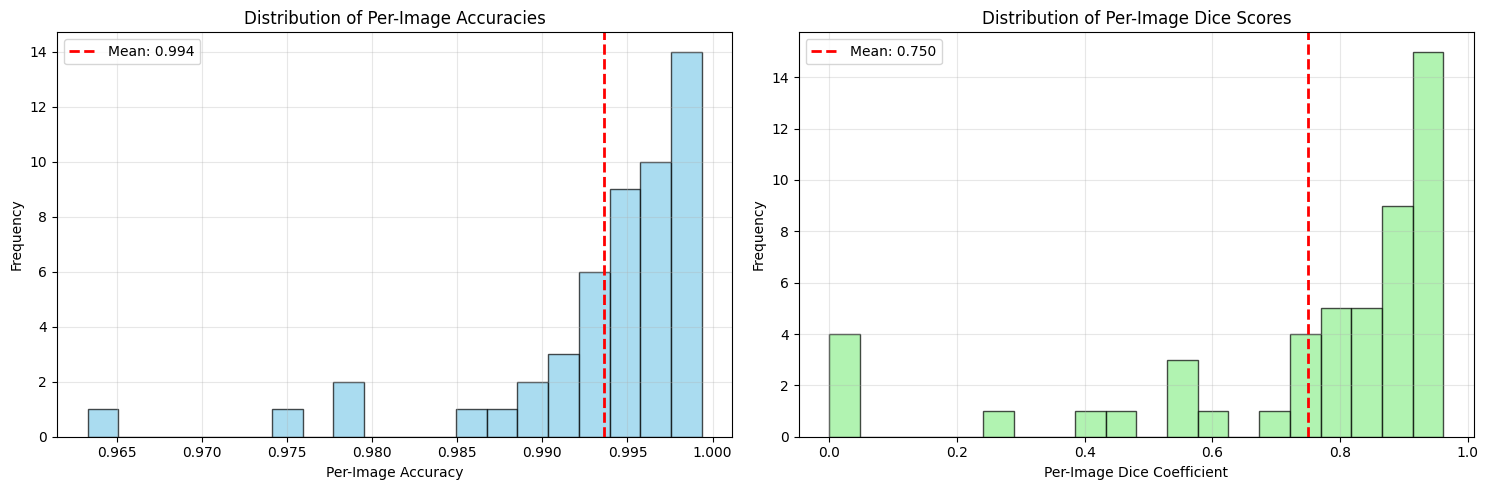

In [42]:
# Method 5: Visual Accuracy Distribution
def plot_accuracy_distribution(per_image_acc, per_image_dice):
    """Plot distribution of accuracies across test images"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy distribution
    ax1.hist(per_image_acc, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(per_image_acc), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(per_image_acc):.3f}')
    ax1.set_xlabel('Per-Image Accuracy')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Per-Image Accuracies')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Dice distribution
    ax2.hist(per_image_dice, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.axvline(np.mean(per_image_dice), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(per_image_dice):.3f}')
    ax2.set_xlabel('Per-Image Dice Coefficient')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Per-Image Dice Scores')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\nMETHOD 5: Accuracy Distribution Visualization")
print("="*40)
plot_accuracy_distribution(per_image_acc, per_image_dice)

In [43]:
# Method 6: Classification Report Style Metrics
def segmentation_classification_report(model, test_pairs, num_samples=100):
    """Generate classification report style metrics for segmentation"""
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    for img_path, mask_path in test_pairs[:num_samples]:
        # Load and preprocess
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image_batch = tf.expand_dims(image, axis=0)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
        mask_binary = tf.where(mask > 0.5, 1.0, 0.0)

        # Predict
        prediction = model.predict(image_batch, verbose=0)[0]
        binary_pred = (prediction > 0.5).astype(np.float32)

        # Calculate confusion matrix components
        true_positives += np.sum((binary_pred == 1) & (mask_binary.numpy() == 1))
        false_positives += np.sum((binary_pred == 1) & (mask_binary.numpy() == 0))
        true_negatives += np.sum((binary_pred == 0) & (mask_binary.numpy() == 0))
        false_negatives += np.sum((binary_pred == 0) & (mask_binary.numpy() == 1))

    # Calculate metrics
    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives
    }

print("\nMETHOD 6: Detailed Classification Report")
print("="*50)
classification_report = segmentation_classification_report(best_model, test_pairs)

print(f"Overall Accuracy: {classification_report['accuracy']:.4f} ({classification_report['accuracy']*100:.2f}%)")
print(f"Precision: {classification_report['precision']:.4f}")
print(f"Recall: {classification_report['recall']:.4f}")
print(f"F1-Score: {classification_report['f1_score']:.4f}")
print(f"\nConfusion Matrix Components:")
print(f"True Positives: {classification_report['true_positives']:.0f}")
print(f"False Positives: {classification_report['false_positives']:.0f}")
print(f"True Negatives: {classification_report['true_negatives']:.0f}")
print(f"False Negatives: {classification_report['false_negatives']:.0f}")


METHOD 6: Detailed Classification Report
Overall Accuracy: 0.9946 (99.46%)
Precision: 0.8861
Recall: 0.7855
F1-Score: 0.8328

Confusion Matrix Components:
True Positives: 88664
False Positives: 11394
True Negatives: 6429330
False Negatives: 24212


In [44]:
# Method 7: Final Summary Report
def generate_final_accuracy_report(model, test_dataset, test_pairs):
    """Generate comprehensive accuracy report"""
    print("🎯 COMPREHENSIVE MODEL ACCURACY REPORT")
    print("="*60)

    # Basic evaluation
    test_loss, test_accuracy, test_dice, test_iou = model.evaluate(test_dataset, verbose=0)

    # Detailed metrics
    detailed_acc = calculate_detailed_accuracy(model, test_dataset)
    per_image_acc, per_image_dice = per_image_accuracy(model, test_pairs, 100)
    class_report = segmentation_classification_report(model, test_pairs, 100)

    print("\n📊 OVERALL PERFORMANCE:")
    print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   Test Dice: {test_dice:.4f}")
    print(f"   Test IoU: {test_iou:.4f}")

    print("\n🎯 SEGMENTATION SPECIFIC METRICS:")
    print(f"   Overall Pixel Accuracy: {detailed_acc['overall_accuracy']:.4f} ({detailed_acc['overall_accuracy']*100:.2f}%)")
    print(f"   Tumor Region Accuracy: {detailed_acc['tumor_accuracy']:.4f} ({detailed_acc['tumor_accuracy']*100:.2f}%)")
    print(f"   Background Accuracy: {detailed_acc['background_accuracy']:.4f} ({detailed_acc['background_accuracy']*100:.2f}%)")

    print("\n📈 PER-IMAGE STATISTICS:")
    print(f"   Average Image Accuracy: {np.mean(per_image_acc):.4f} (±{np.std(per_image_acc):.4f})")
    print(f"   Average Image Dice: {np.mean(per_image_dice):.4f} (±{np.std(per_image_dice):.4f})")
    print(f"   Accuracy Range: {np.min(per_image_acc):.4f} - {np.max(per_image_acc):.4f}")

    print("\n🎭 CLASSIFICATION METRICS:")
    print(f"   Precision: {class_report['precision']:.4f}")
    print(f"   Recall: {class_report['recall']:.4f}")
    print(f"   F1-Score: {class_report['f1_score']:.4f}")

    print("\n💡 INTERPRETATION:")
    if test_accuracy > 0.90:
        print("   ✅ EXCELLENT: Model accuracy is very high (>90%)")
    elif test_accuracy > 0.80:
        print("   ✅ GOOD: Model accuracy is good (>80%)")
    elif test_accuracy > 0.70:
        print("   ⚠️  FAIR: Model accuracy is acceptable (>70%)")
    else:
        print("   ❌ NEEDS IMPROVEMENT: Model accuracy is below 70%")

    if detailed_acc['tumor_accuracy'] > 0.75:
        print("   ✅ GOOD: Tumor detection accuracy is satisfactory")
    else:
        print("   ⚠️  CAUTION: Tumor detection needs improvement")

    print("="*60)

# Generate final comprehensive report
generate_final_accuracy_report(best_model, test_dataset, test_pairs)

🎯 COMPREHENSIVE MODEL ACCURACY REPORT

📊 OVERALL PERFORMANCE:
   Test Accuracy: 0.9948 (99.48%)
   Test Dice: 0.8339
   Test IoU: 0.7203

🎯 SEGMENTATION SPECIFIC METRICS:
   Overall Pixel Accuracy: 0.9948 (99.48%)
   Tumor Region Accuracy: 0.8118 (81.18%)
   Background Accuracy: 0.9980 (99.80%)

📈 PER-IMAGE STATISTICS:
   Average Image Accuracy: 0.9946 (±0.0062)
   Average Image Dice: 0.7849 (±0.2465)
   Accuracy Range: 0.9633 - 0.9996

🎭 CLASSIFICATION METRICS:
   Precision: 0.8861
   Recall: 0.7855
   F1-Score: 0.8328

💡 INTERPRETATION:
   ✅ EXCELLENT: Model accuracy is very high (>90%)
   ✅ GOOD: Tumor detection accuracy is satisfactory
